# Single Scatterer Position Detection Experiment Setup

This notebook is used to verify and prepare the experimental setup for testing position detection performance with a single strong scatterer. The goal is to evaluate how different electromagnetic imaging algorithms perform when trying to locate a single object with high dielectric contrast in a challenging scenario.

## Experiment Overview
- **Test Problem**: Single 5-pointed star scatterer with strong dielectric contrast
- **Primary Focus**: Position error evaluation ($\zeta_P$ indicator)
- **Secondary Focus**: Shape error evaluation ($\zeta_S$ indicator) and objective function analysis
- **Scenario**: Strong scatterer (χ = 5.0) where traditional Born approximation fails
- **Application**: Foundation for understanding algorithm limitations in strong scattering regimes

## Problem Configuration

Setting up the experimental parameters for single scatterer position detection:

### Key Parameters:
- **Domain size**: 2λ × 2λ (square imaging domain)
- **Resolution**: 160×160 pixels for detailed ground truth representation
- **Noise level**: 5% additive noise to simulate realistic measurement conditions
- **Number of sources/measurements**: 80 each (circular array configuration)
- **Observation radius**: 4λ from the imaging domain center

### Single Scatterer Properties:
- **Shape**: 5-pointed star with characteristic size l = 0.3λ
- **Dielectric contrast**: εᵣ = 6.0 (very strong scatterer)
- **Contrast parameter**: χ = (εᵣ - εᵦ)/εᵦ = 5.0
- **Position**: Located at (0.4λ, -0.4λ) - off-center to test position detection
- **Rotation**: 30° rotation to add geometric complexity

### Why This Configuration?
This represents a **challenging strong scattering scenario** where:
1. Born approximation assumptions are violated (χ >> 1)
2. Multiple scattering effects become significant
3. Position detection becomes more relevant than shape reconstruction
4. Algorithm robustness can be properly evaluated

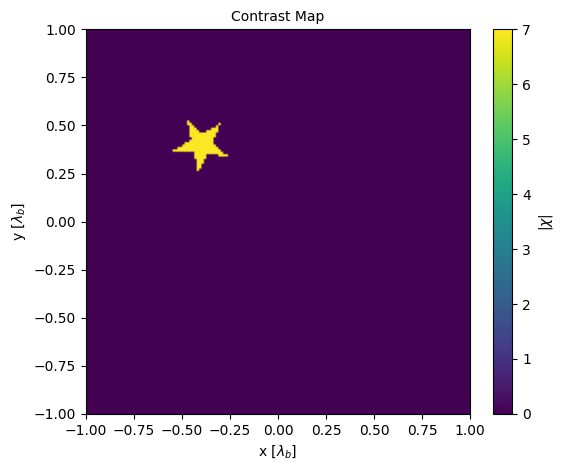

Execution time: 5.71 [sec]
DNL: 1.743761409138808
DNL: 1.743761409138808


In [1]:
import sys
sys.path.insert(1, '../../../eispy2d/library/')

import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom

# Parameters
name = 'single'
file_path = "../../../data/position/single/"
NM = NS = 80
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True
resolution = (160, 160)
noise = 5.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR, rst.OBJECTIVE_FUNCTION]
epsilon_rd = 8. # 6.00
l = 0.15
position = [.4, -.4]
rotate = 30

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro, 
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)


test = ipt.InputData(name=name + '.ipt', configuration=config, 
                     resolution=resolution, noise=noise, indicators=indicators)

chi = (epsilon_rd-epsilon_rb)/epsilon_rb

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd,
    center=position, rotate=30.
)

test.draw(show=True)

forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=10000,
                         parallelization=True)

_ = forward.solve(test, PRINT_INFO=True)

test.compute_dnl()
print('DNL:', test.dnl)

## Algorithm Performance Evaluation

Now testing different electromagnetic imaging algorithms on this single strong scatterer to evaluate their position detection capabilities. Each algorithm represents a different approach to solving the inverse scattering problem.

### Reconstruction Resolution:
- **Discretization**: 40×40 elements (sufficient for position detection)
- **Method**: Richmond discretization scheme
- **Trade-off**: Balance between computational efficiency and accuracy

### 1. Subspace-Based Optimization Method (SOM)

Testing SOM with eigenvalue decomposition approach:
- **Method**: Subspace-Based Optimization Method
- **Stop criteria**: Maximum 30 iterations
- **Cutoff index**: 5 (number of significant eigenvalues considered)
- **Expected behavior**: Should handle strong scatterers well due to its iterative nature
- **Advantages**: Less sensitive to Born approximation violations

Method: Subspace-based Optimization Method
Alias: som
Input Data: single.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 30
Iteration: 1 -  Shape: 67.08, Position: 0.61, Ob. Func.: 9.320e+01,
Iteration: 1 -  Shape: 67.08, Position: 0.61, Ob. Func.: 9.320e+01,
Iteration: 2 -  Shape: 59.58, Position: 0.80, Ob. Func.: 7.909e+01,
Iteration: 2 -  Shape: 59.58, Position: 0.80, Ob. Func.: 7.909e+01,
Iteration: 3 -  Shape: 53.33, Position: 1.37, Ob. Func.: 6.763e+01,
Iteration: 3 -  Shape: 53.33, Position: 1.37, Ob. Func.: 6.763e+01,
Iteration: 4 -  Shape: 54.58, Position: 1.35, Ob. Func.: 5.842e+01,
Iteration: 4 -  Shape: 54.58, Position: 1.35, Ob. Func.: 5.842e+01,
Iteration: 5 -  Shape: 54.58, Position: 1.35, Ob. Func.: 5.133e+01,
Iteration: 5 -  Shape: 54.58, Position: 1.35, Ob. Func.: 5.133e+01,
Iteration: 6 -  Shape: 54.58, Position: 1.35, Ob. Func.: 4.480e+01,
Iteration: 6 -  Shape: 5

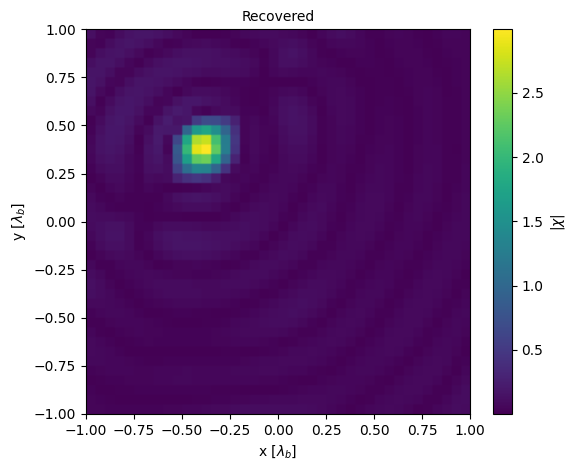

In [2]:
import som
import stopcriteria as stp
import richmond as ric

resolution = (40, 40)
discretization = ric.Richmond(configuration=config,
                              elements=resolution)

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=30), cutoff_index=5
)

result = method.solve(test, discretization, print_info=True)

result.plot_map(show=True)

### 2. Orthogonality Sampling Method (OSM)

Testing OSM for qualitative imaging and position detection:
- **Method**: Orthogonality Sampling Method
- **Threshold**: 0.35 (controls detection sensitivity)
- **Expected behavior**: Excellent position detection capabilities, particularly robust for strong scatterers
- **Advantages**: 
  - Indicator function approach provides clear spatial localization
  - Robust to noise and modeling errors
  - No need for a priori knowledge of scatterer properties

Method: Orthogonality Sampling Method
Alias: osm
Input Data: single.ipt
Discretization: Richmond Method (40x40)
Threshold: 0.35


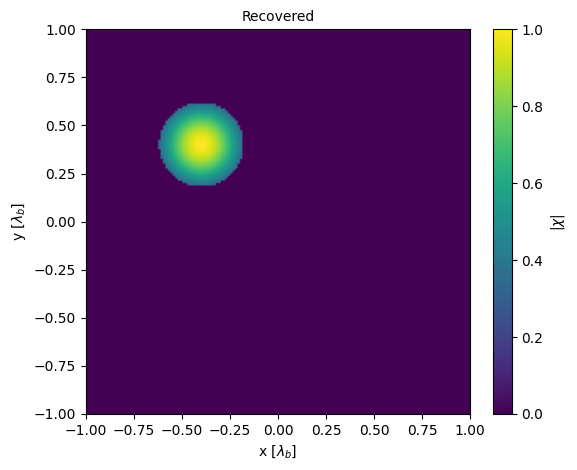

In [3]:
import osm
method = osm.OrthogonalitySamplingMethod(threshold=.35)
result = method.solve(test, discretization, print_info=True)
result.plot_map(show=True)

### 3. Circle Approximation Method (CA)

Testing a parametric approach with geometric constraints:
- **Method**: Circle Approximation with Differential Evolution optimizer
- **Contrast range**: 0.1 to 10.0 (covers weak to very strong scatterers)
- **Solver**: Differential Evolution (DE) - global optimization algorithm
- **Number of executions**: 1 (deterministic for this verification)
- **Expected behavior**: 
  - Should provide good position detection for circular-like objects
  - May struggle with complex star geometry but useful for position estimation
- **Advantages**: 
  - Parametric approach reduces dimensionality
  - Global optimization helps avoid local minima
  - Provides both position and contrast estimates

Method: 
Alias: ca
Input Data: single.ipt
Discretization: Richmond Method (40x40)
Parallelization: False
Number of executions: 1
Output rule: each
Position range: None
Radius range: None
Contrast range: [0.1, 10.0]
--------------------------------------------------
Execution: 0
Iteration: 1 - f(x): 99.31200984339984
--------------------------------------------------
Execution: 0
Iteration: 1 - f(x): 99.31200984339984
Iteration: 2 - f(x): 87.01789959149785
Iteration: 2 - f(x): 87.01789959149785
Iteration: 3 - f(x): 81.4188111723756
Iteration: 3 - f(x): 81.4188111723756
Iteration: 4 - f(x): 63.30967682603224
Iteration: 4 - f(x): 63.30967682603224
Iteration: 5 - f(x): 63.30967682603224
Iteration: 5 - f(x): 63.30967682603224
Iteration: 6 - f(x): 56.64305663651092
Iteration: 6 - f(x): 56.64305663651092
Iteration: 7 - f(x): 43.65494206866362
Iteration: 7 - f(x): 43.65494206866362
Iteration: 8 - f(x): 43.65494206866362
Iteration: 8 - f(x): 43.65494206866362
Iteration: 9 - f(x): 43.65494206866

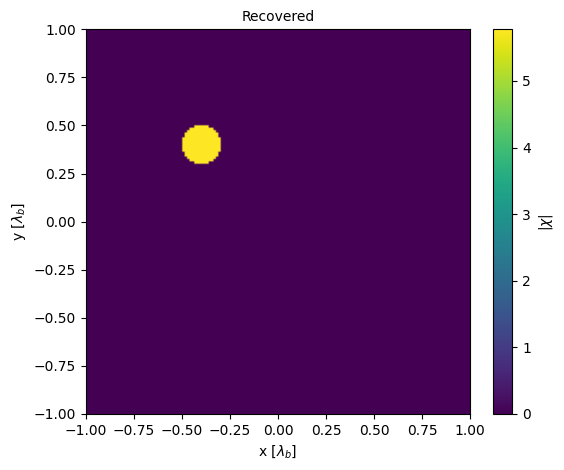

In [4]:
import circleapproximation as ca
import stochastic as stc

import richmond as ric

resolution = (40, 40)
discretization = ric.Richmond(configuration=config,
                              elements=resolution)

contrast_range = (0.1, 10.)

method = ca.CircleApproximation(stc.OutputMode(stc.EACH_EXECUTION),
                                number_executions=1,
                                contrast_range=contrast_range,
                                solver="de")

result = method.solve(test, discretization, print_info=True)
result.plot_map(show=True)


## Next Steps:
This preliminary validation confirms:
1. The problem setup is appropriate for position detection studies
2. The algorithms show different strengths for this scenario  
3. The configuration is ready for statistical benchmarking with multiple noise realizations
4. Position error indicator ζ_P will be meaningful for this strong scatterer case